In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import yfinance as yf
from stock_data import StockData
import datetime
from hmmlearn import hmm
from matplotlib.dates import YearLocator, MonthLocator


ticker = 'SPY'
end_date = datetime.date.today()
start_date = pd.to_datetime(end_date) - pd.DateOffset(months=6*12)
data_interval = '1d'

stock = StockData(ticker, start_date, end_date, data_interval)
data = stock.history

data['Date'] = stock.history.index.values

stock.candlestick

In [12]:
returns_ratio = np.divide(data["Close"].shift(1).values.tolist(),data["Close"].values.tolist())
log_returns = np.log(returns_ratio)
log_returns_df = pd.DataFrame(log_returns).set_index(data.index).dropna()
X = log_returns_df.values.reshape(-1, 1)


best_score = None
try_components = [2, 3, 4, 5]

for n in try_components:
    for i in range(10):
        try_model = hmm.GaussianHMM(n_components=n, covariance_type="diag", n_iter=1000)
        try_model.fit(X)
        score = try_model.aic(X)
        if best_score is None or score < best_score:
            best_score = score
            model = try_model
        #print("{} Components on Iteration {}, AIC: {}".format(n, i+1, score))

Model is not converging.  Current: 4749.86658351403 is not greater than 4750.106842231006. Delta is -0.24025871697631374
Model is not converging.  Current: 4721.977358297558 is not greater than 4722.361806996508. Delta is -0.38444869895010925
Model is not converging.  Current: 4837.3261475284735 is not greater than 4837.374904596497. Delta is -0.048757068023405736
Model is not converging.  Current: 4837.342841509093 is not greater than 4837.38712591315. Delta is -0.04428440405717993
Model is not converging.  Current: 4716.506503999227 is not greater than 4716.7714838669335. Delta is -0.26497986770664284
Model is not converging.  Current: 4837.136116634026 is not greater than 4837.166815132799. Delta is -0.030698498772835592
Model is not converging.  Current: 4836.6990277596915 is not greater than 4836.823977191074. Delta is -0.12494943138244707
Model is not converging.  Current: 4836.619882560002 is not greater than 4836.639728014291. Delta is -0.01984545428877027
Model is not convergi

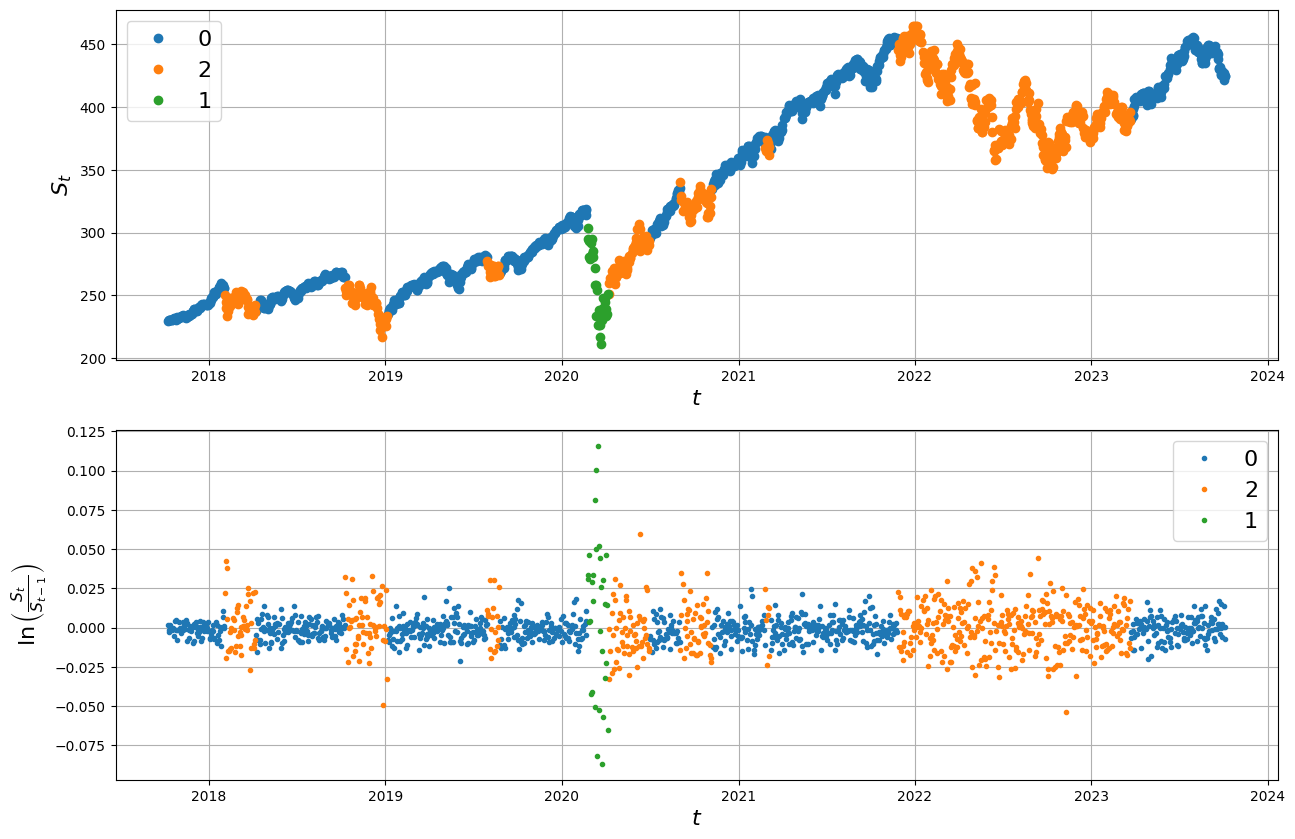

In [13]:
Z=model.predict(X)
states=pd.unique(Z)

plt.figure(figsize = (15, 10))
plt.subplot(2,1,1)
for i in states:
    want = (Z == i)
    y = data["Close"].tail(-1).iloc[want]
    x = data["Date"].tail(-1).iloc[want]
    plt.plot(x, y, '.', linewidth=2, markersize=12)
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$S_t$', fontsize=16)
plt.subplot(2,1,2)
for i in states:
    want = (Z == i)
    y = log_returns_df.iloc[want]
    x = data["Date"].tail(-1).iloc[want]
    plt.plot(x, y, '.')
plt.legend(states, fontsize=16)
plt.grid(True)
plt.xlabel(r'$t$', fontsize=16)
plt.ylabel(r'$\ln\left(\frac{S_t}{S_{t-1}}\right)$', fontsize=16)
plt.show()

In [14]:
for state in range(len(states)):
    print("State {}: Mean = {}".format(state, model.means_[state][0]))

State 0: Mean = -0.001179970894370023
State 1: Mean = 0.006199185714826212
State 2: Mean = 0.0004534606606538096


In [15]:
for state in range(len(states)):
    print("State {}: Covariances = {}".format(state, model.covars_[state][0]))

State 0: Covariances = [5.36666295e-05]
State 1: Covariances = [0.00266312]
State 2: Covariances = [0.00024317]
